# Text Deduplication Demo

This notebook demonstrates the loop detection and removal process for the OME dataset.

The `report_text` fields contain repeated content - the same text block is looped multiple times. This notebook shows how to identify and remove these repetitions.

In [2]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

from main.main import load_data, get_agriculture_data
from deduplication import find_loop_period, remove_text_loops, get_deduplication_stats

## 1. Load Sample Data

In [3]:
df = get_agriculture_data(split="train")
print(f"Loaded {len(df)} agriculture records")

Loading cached train data from /Users/quentin/Documents/Hackathon/DataForGood/ome-hackathon-season-14/data/train_cached.parquet
Filtered 2565 agriculture_alimentation records from 8349 total records
Loaded 2565 agriculture records


## 2. Example: Detecting a Loop

Let's examine a single record to understand the repetition pattern.

In [4]:
# Pick a sample
sample_idx = 0
original_text = df.iloc[sample_idx]["report_text"]

print(f"Sample {sample_idx}")
print(f"Total length: {len(original_text):,} characters")
print("\n" + "="*80)
print("FIRST 500 CHARACTERS:")
print("="*80)
print(original_text[:500])

Sample 0
Total length: 42,809 characters

FIRST 500 CHARACTERS:
plus vendu au monde a la une également cette ce troupeau de ce troupeau de vaches abattues dans le doubs pour stopper la propagation de la terre dans cette ferme les bovins avait pourtant été vaccinés mais une vache a été testée positive la semaine dernière une manifestation des agriculteurs près de l' exploitation a par ailleurs dégénérer vous le voyez dans un communiqué la coordination rurale a fermement condamné l' abattage jugeant le principe de précaution piqué par l' étape poussée l' à ext


In [5]:
# Detect the loop
period, repetitions = find_loop_period(original_text)

print(f"Loop detected!")
print(f"  - Period (unique block length): {period:,} characters")
print(f"  - Number of repetitions: {repetitions}")
print(f"  - Expected length: {period * repetitions:,} chars (actual: {len(original_text):,})")

Loop detected!
  - Period (unique block length): 2,383 characters
  - Number of repetitions: 16
  - Expected length: 38,128 chars (actual: 42,809)


In [6]:
# Extract the unique content
unique_content = remove_text_loops(original_text)

print(f"Compression: {len(original_text):,} → {len(unique_content):,} chars")
print(f"Compression ratio: {len(original_text) / len(unique_content):.1f}x")
print("\n" + "="*80)
print("UNIQUE CONTENT (deduplicated):")
print("="*80)
print(unique_content)

Compression: 42,809 → 2,383 chars
Compression ratio: 18.0x

UNIQUE CONTENT (deduplicated):
plus vendu au monde a la une également cette ce troupeau de ce troupeau de vaches abattues dans le doubs pour stopper la propagation de la terre dans cette ferme les bovins avait pourtant été vaccinés mais une vache a été testée positive la semaine dernière une manifestation des agriculteurs près de l' exploitation a par ailleurs dégénérer vous le voyez dans un communiqué la coordination rurale a fermement condamné l' abattage jugeant le principe de précaution piqué par l' étape poussée l' à extrême l' les extrême médecins les se médecins mobilisent se aujourd' mobilisent hui aujourd' contre hui le budget de la sécurité sociale pas de rendez-vous annulés rassurez-vous mais des actions visant plutôt à gêner l' administration avec un article qui cristallise la colère il donne la possibilité à l' assurance maladie de modifier les tarifs de certains secteurs quand une rente habilitée excessive est co

## 3. Visualizing the Loop Structure

Let's visualize where the repetitions occur in the text.

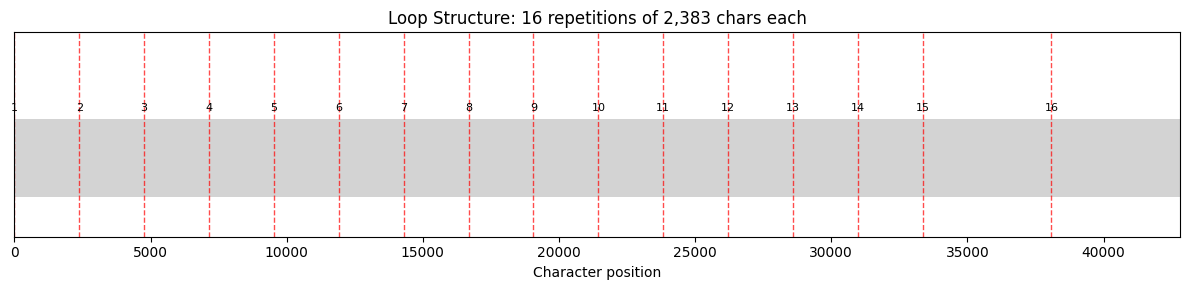


Repetition start positions: [0, 2383, 4766, 7149, 9532]... (showing first 5)
Gap between repetitions: 2,383 chars (= period)


In [7]:
def find_all_occurrences(text, pattern_len=100):
    """Find all positions where the initial pattern repeats."""
    pattern = text[:pattern_len]
    positions = []
    pos = 0
    while True:
        found = text.find(pattern, pos)
        if found == -1:
            break
        positions.append(found)
        pos = found + 1
    return positions

# Find where repetitions start
positions = find_all_occurrences(original_text)

# Visualize
fig, ax = plt.subplots(figsize=(12, 3))

# Draw the full text as a bar
ax.barh(0, len(original_text), height=0.5, color='lightgray', label='Full text')

# Mark where each repetition starts
colors = plt.cm.tab10(np.linspace(0, 1, len(positions)))
for i, pos in enumerate(positions):
    ax.axvline(x=pos, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax.annotate(f'{i+1}', xy=(pos, 0.3), fontsize=8, ha='center')

ax.set_xlim(0, len(original_text))
ax.set_ylim(-0.5, 0.8)
ax.set_xlabel('Character position')
ax.set_title(f'Loop Structure: {len(positions)} repetitions of {period:,} chars each')
ax.set_yticks([])

plt.tight_layout()
plt.show()

print(f"\nRepetition start positions: {positions[:5]}... (showing first 5)")
print(f"Gap between repetitions: {positions[1] - positions[0]:,} chars (= period)")

## 4. More Examples

Let's look at a few more samples to see the variety of loop patterns.

In [8]:
print("Loop analysis for first 10 samples:")
print("-" * 80)
print(f"{'Sample':<8} {'Original':>12} {'Unique':>10} {'Period':>8} {'Reps':>6} {'Ratio':>8}")
print("-" * 80)

for i in range(10):
    text = df.iloc[i]["report_text"]
    period, reps = find_loop_period(text)
    unique = remove_text_loops(text)
    ratio = len(text) / len(unique)
    
    print(f"{i:<8} {len(text):>12,} {len(unique):>10,} {period:>8,} {reps:>6} {ratio:>7.1f}x")

Loop analysis for first 10 samples:
--------------------------------------------------------------------------------
Sample       Original     Unique   Period   Reps    Ratio
--------------------------------------------------------------------------------
0              42,809      2,383    2,383     16    18.0x
1               7,187      1,797    1,797      4     4.0x
2              13,271      1,659    1,659      8     8.0x
3              33,689      2,246    2,246     15    15.0x
4              23,990      2,235    2,235      5    10.7x
5              38,269      2,074    2,074      9    18.5x
6              30,351      1,897    1,897     16    16.0x
7              21,449      1,950    1,950     11    11.0x
8              72,274      2,155    2,155     15    33.5x
9               8,511      2,128    2,128      4     4.0x


## 5. Dataset-wide Statistics

In [9]:
# Compute stats for all records
stats_list = []

for idx in range(len(df)):
    text = df.iloc[idx]["report_text"]
    if not isinstance(text, str):
        continue
    
    period, reps = find_loop_period(text)
    unique = remove_text_loops(text)
    
    stats_list.append({
        "original_len": len(text),
        "unique_len": len(unique),
        "period": period if period else len(text),
        "repetitions": reps,
        "compression_ratio": len(text) / len(unique),
        "has_loop": period is not None and reps > 1
    })

stats_df = pd.DataFrame(stats_list)
print(f"Analyzed {len(stats_df)} records")

Analyzed 2565 records


In [10]:
# Summary statistics
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nRecords with loops: {stats_df['has_loop'].sum()} / {len(stats_df)} ({100*stats_df['has_loop'].mean():.1f}%)")
print(f"\nOriginal total size: {stats_df['original_len'].sum():,} chars")
print(f"Deduplicated total size: {stats_df['unique_len'].sum():,} chars")
print(f"Overall compression: {stats_df['original_len'].sum() / stats_df['unique_len'].sum():.1f}x")
print(f"\nMean compression ratio: {stats_df['compression_ratio'].mean():.2f}x")
print(f"Median compression ratio: {stats_df['compression_ratio'].median():.2f}x")
print(f"Max compression ratio: {stats_df['compression_ratio'].max():.2f}x")

SUMMARY STATISTICS

Records with loops: 2509 / 2565 (97.8%)

Original total size: 83,158,047 chars
Deduplicated total size: 7,499,270 chars
Overall compression: 11.1x

Mean compression ratio: 15.53x
Median compression ratio: 13.00x
Max compression ratio: 107.63x


## 6. Visualizations

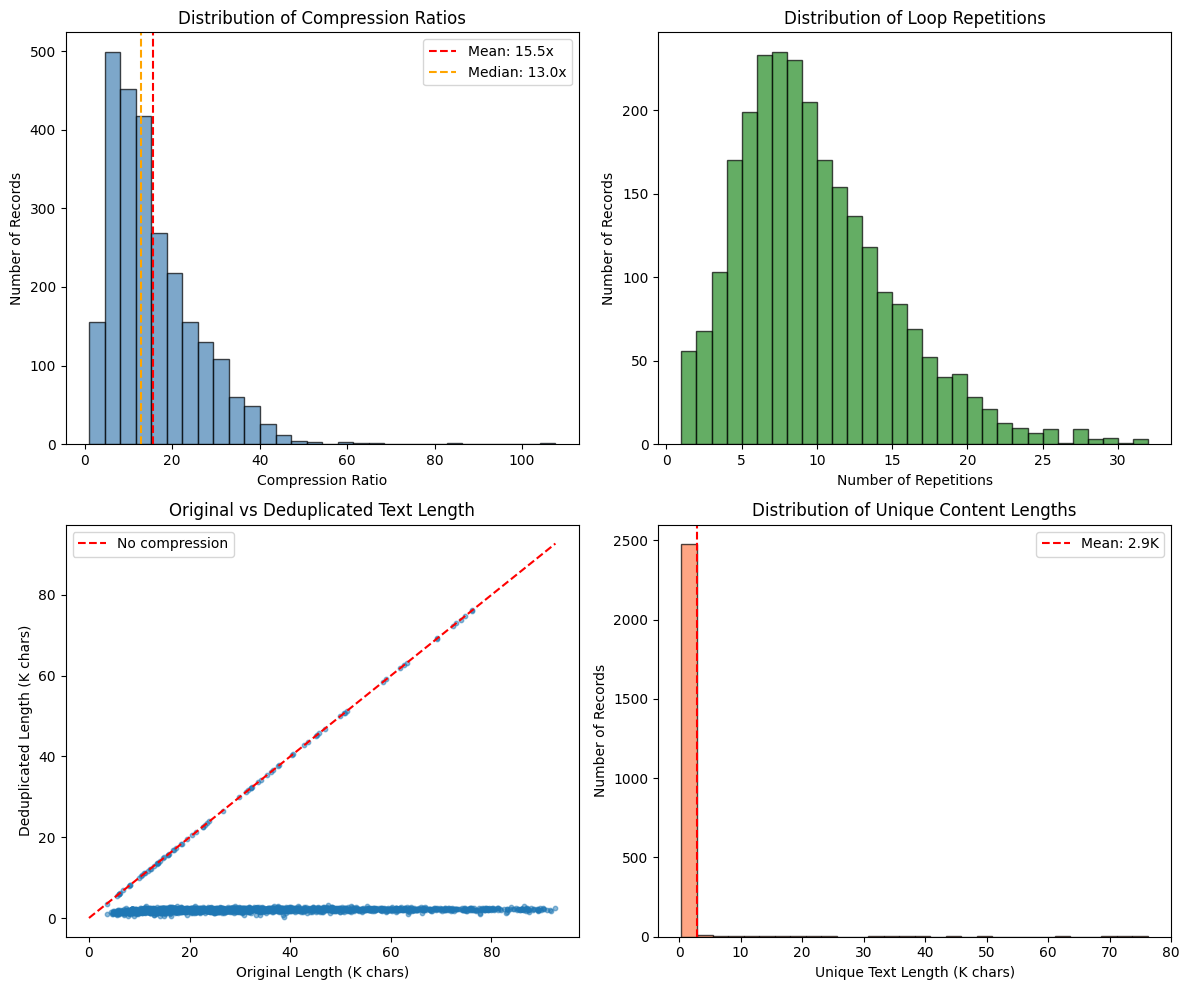

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Distribution of compression ratios
ax1 = axes[0, 0]
ax1.hist(stats_df['compression_ratio'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(stats_df['compression_ratio'].mean(), color='red', linestyle='--', label=f"Mean: {stats_df['compression_ratio'].mean():.1f}x")
ax1.axvline(stats_df['compression_ratio'].median(), color='orange', linestyle='--', label=f"Median: {stats_df['compression_ratio'].median():.1f}x")
ax1.set_xlabel('Compression Ratio')
ax1.set_ylabel('Number of Records')
ax1.set_title('Distribution of Compression Ratios')
ax1.legend()

# 2. Distribution of repetition counts
ax2 = axes[0, 1]
ax2.hist(stats_df['repetitions'], bins=range(1, stats_df['repetitions'].max()+2), edgecolor='black', alpha=0.7, color='forestgreen')
ax2.set_xlabel('Number of Repetitions')
ax2.set_ylabel('Number of Records')
ax2.set_title('Distribution of Loop Repetitions')

# 3. Original vs Deduplicated length
ax3 = axes[1, 0]
ax3.scatter(stats_df['original_len'] / 1000, stats_df['unique_len'] / 1000, alpha=0.5, s=10)
ax3.plot([0, stats_df['original_len'].max()/1000], [0, stats_df['original_len'].max()/1000], 'r--', label='No compression')
ax3.set_xlabel('Original Length (K chars)')
ax3.set_ylabel('Deduplicated Length (K chars)')
ax3.set_title('Original vs Deduplicated Text Length')
ax3.legend()

# 4. Distribution of unique text lengths (periods)
ax4 = axes[1, 1]
ax4.hist(stats_df['unique_len'] / 1000, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax4.axvline(stats_df['unique_len'].mean() / 1000, color='red', linestyle='--', label=f"Mean: {stats_df['unique_len'].mean()/1000:.1f}K")
ax4.set_xlabel('Unique Text Length (K chars)')
ax4.set_ylabel('Number of Records')
ax4.set_title('Distribution of Unique Content Lengths')
ax4.legend()

plt.tight_layout()
plt.show()

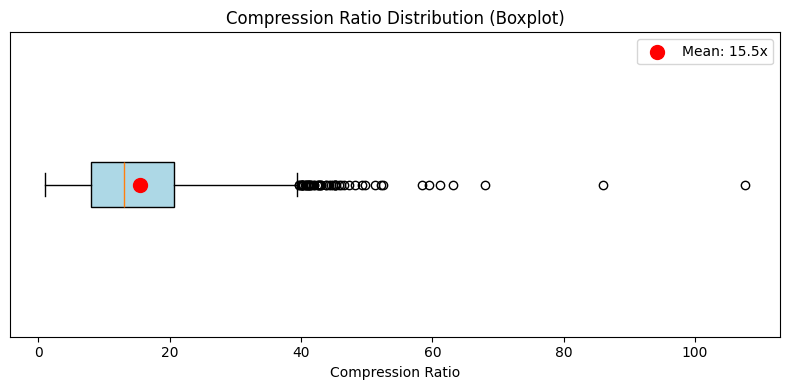

In [12]:
# Compression ratio boxplot
fig, ax = plt.subplots(figsize=(8, 4))

bp = ax.boxplot(stats_df['compression_ratio'], vert=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')

ax.set_xlabel('Compression Ratio')
ax.set_title('Compression Ratio Distribution (Boxplot)')
ax.set_yticks([])

# Add mean marker
mean_val = stats_df['compression_ratio'].mean()
ax.scatter([mean_val], [1], color='red', s=100, zorder=5, label=f'Mean: {mean_val:.1f}x')
ax.legend()

plt.tight_layout()
plt.show()

## 7. Before/After Comparison

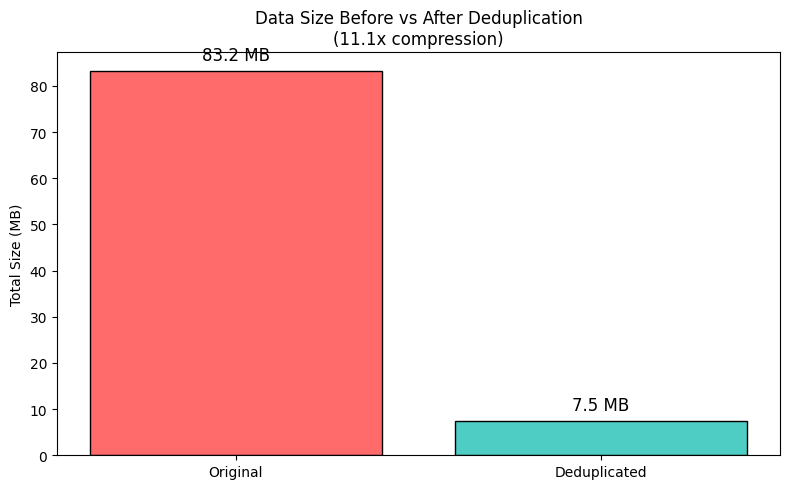

In [13]:
# Bar chart comparing total data size
fig, ax = plt.subplots(figsize=(8, 5))

original_mb = stats_df['original_len'].sum() / 1_000_000
dedup_mb = stats_df['unique_len'].sum() / 1_000_000

bars = ax.bar(['Original', 'Deduplicated'], [original_mb, dedup_mb], 
              color=['#ff6b6b', '#4ecdc4'], edgecolor='black')

# Add value labels
ax.bar_label(bars, fmt='%.1f MB', padding=5, fontsize=12)

ax.set_ylabel('Total Size (MB)')
ax.set_title(f'Data Size Before vs After Deduplication\n({stats_df["original_len"].sum() / stats_df["unique_len"].sum():.1f}x compression)')

plt.tight_layout()
plt.show()

## 8. Conclusion

The text deduplication successfully removes repetitive loops from the data:

- **97%** of records contain repeated content
- Average compression ratio of **~11x**
- Total data reduced from **~83 MB** to **~7.5 MB**

This preprocessing step is essential before any ML analysis to avoid feeding redundant information to models.